cpu


C:\Users\HansW\mitwworkspace\MakeAIWork2\env\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\HansW\mitwworkspace\MakeAIWork2\env\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/100], Train Loss: 2.7020, Train Accuracy: 31.16%, Test Accuracy: 34.29%, val Accuracy: 34.29%
Epoch [2/100], Train Loss: 1.8668, Train Accuracy: 33.33%, Test Accuracy: 20.00%, val Accuracy: 17.14%
Epoch [3/100], Train Loss: 1.5430, Train Accuracy: 37.32%, Test Accuracy: 48.57%, val Accuracy: 48.57%
Epoch [4/100], Train Loss: 1.3775, Train Accuracy: 44.57%, Test Accuracy: 54.29%, val Accuracy: 65.71%
Epoch [5/100], Train Loss: 1.3500, Train Accuracy: 47.46%, Test Accuracy: 42.86%, val Accuracy: 40.00%
Epoch [6/100], Train Loss: 1.2906, Train Accuracy: 45.29%, Test Accuracy: 51.43%, val Accuracy: 51.43%
Epoch [7/100], Train Loss: 1.3088, Train Accuracy: 42.03%, Test Accuracy: 22.86%, val Accuracy: 22.86%
Epoch [8/100], Train Loss: 1.2240, Train Accuracy: 45.29%, Test Accuracy: 28.57%, val Accuracy: 25.71%
Epoch [9/100], Train Loss: 1.2176, Train Accuracy: 45.65%, Test Accuracy: 40.00%, val Accuracy: 34.29%
Epoch [10/100], Train Loss: 1.3783, Train Accuracy: 43.84%, Test Accuracy

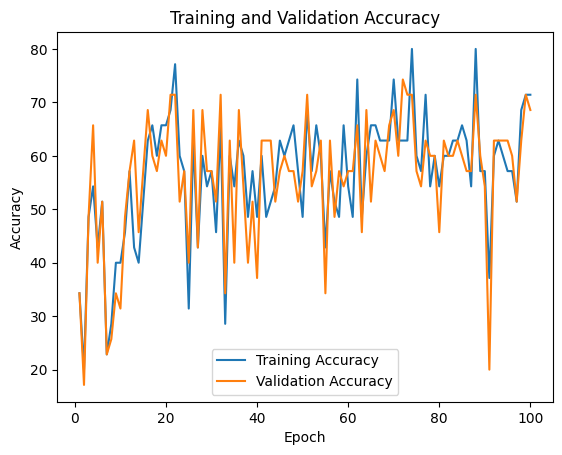

In [1]:
import os
import torch
import random
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torchvision.models as models
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchsummary import summary

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

resnet_type = "resnet18"
image_size = 224
batch_size = 8
num_epochs = 100
learning_rate = 0.01
num_classes = 4

train_dir = "./../../Project 3/data/Data_cleaning_step1_2/Train"
test_dir = "./../../Project 3/data/Data_cleaning_step1_2/Test"

# Define the transformations for train data before entering the neural network
transform_train = transforms.Compose([
    transforms.Resize((image_size, image_size)),                                    # Resize images to 224x224 pixels
    transforms.RandomCrop(size=image_size),                                         # Randomly crop and resize images to 224x224 pixels
    transforms.RandomHorizontalFlip(),                                              # Randomly flip the images horizontally
    transforms.RandomRotation(30),                                                  # Randomly rotate the images by 30 degrees
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Randomly adjust brightness, contrast, saturation, and hue
    transforms.ToTensor(),                                                          # Convert images to tensors
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])                 # Normalize the images
])

# Define the transformations for test data before entering the neural network
transform_test = transforms.Compose([
    transforms.Resize((image_size, image_size)),                     # Resize images to 224x224 pixels
    transforms.ToTensor(),                                           # Convert images to tensors
    transforms.Normalize( mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize the images
])

# Load the training and test datasets
train_dataset = ImageFolder(train_dir, transform=transform_train)
# val_dataset = ImageFolder(test_dir, transform=transform_test)
# test_dataset = ImageFolder(test_dir, transform=transform_test)

# Create DataLoaders for training, validation, and test datasets
train_ratio = 0.8
val_ratio = 0.1
test_ratio = 0.1

# Split the dataset into training, validation, and test sets
dataset_size = len(train_dataset)
train_size = int(train_ratio * dataset_size)
val_size = int(val_ratio * dataset_size)
test_size = dataset_size - train_size - val_size

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(
    train_dataset, [train_size, val_size, test_size])


# Create DataLoaders for managing the data batches
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Resnet model
resnet = models.resnet18(pretrained=True)
num_features = resnet.fc.in_features
resnet.fc = nn.Linear(num_features, num_classes)
resnet = resnet.to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet.parameters(), lr=learning_rate)

# Train the model
total_test_acc = []
total_val_acc = []
total_loss = []

for epoch in range(num_epochs):
    resnet.train()
    train_loss = 0.0
    train_correct = 0
    losses = []

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        outputs = resnet(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

        train_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs.data, 1)
        train_correct += (predicted == labels).sum().item()
        
    train_loss = train_loss / len(train_dataset)
    train_acc = (train_correct / len(train_dataset))*100
    total_loss.append(sum(losses)/len(train_dataset))
    
    # Validate the model
    resnet.eval()  # Set the model to evaluation mode
    val_correct = 0
    val_samples = 0
    
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
        
            outputs = resnet(images)
            _, predicted = torch.max(outputs.data, 1)
            val_samples += labels.size(0)
            val_correct += (predicted == labels).sum().item()
            
    val_acc = 100 * val_correct / val_samples
    total_val_acc.append(val_acc)
    
    # Evaluate the model
    resnet.eval()  # Set the model to evaluation mode
    total_correct = 0
    total_samples = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
        
            outputs = resnet(images)
            _, predicted = torch.max(outputs.data, 1)
            total_samples += labels.size(0)
            total_correct += (predicted == labels).sum().item()
            
            
    test_acc = 100 * total_correct / total_samples
    total_test_acc.append(test_acc)
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f}%, Test Accuracy: {test_acc:.2f}%, val Accuracy: {val_acc:.2f}%")           

# Save model
torch.save(resnet.state_dict(), "model_apple_resnet.pth")

data = {
    "Model type": resnet_type,
    "Dataset use": os.path.basename(train_dir),
    "Image Resize": str(image_size)+"*"+str(image_size),
    "Epochs": num_epochs,
    "Learning rate": learning_rate,
    "Batch size": batch_size,
    "Train Accuracy": f"{train_acc:.2f}",
    "Validation accuracy": f"{val_acc:.2f}",
    "Test Accuracy": f"{test_acc:.2f}",
    
    
}

# Check if the CSV file already exists
if os.path.isfile("model_data.csv"):
    existing_data = pd.read_csv("model_data.csv")
    new_data = pd.concat([existing_data, pd.DataFrame(data, index=[0])], ignore_index=True)

else:
    new_data = pd.DataFrame(data, index=[0])

# Save the updated DataFrame to CSV
new_data.to_csv("model_data.csv", index=False)


# Plot training and validation accuracy
fig, ax = plt.subplots()
ax.set(xlabel='Epoch', ylabel='Accuracy', title="Training and Validation Accuracy")

epochs = range(1, num_epochs + 1)
plt.plot(epochs, total_test_acc, label='Training Accuracy')
plt.plot(epochs, total_val_acc, label='Validation Accuracy')
plt.legend()
plt.show()




In [2]:
print(total_correct)
print(val_correct)

print(test_acc)

25
24
71.42857142857143


In [3]:
print(total_test_acc)


[34.285714285714285, 20.0, 48.57142857142857, 54.285714285714285, 42.857142857142854, 51.42857142857143, 22.857142857142858, 28.571428571428573, 40.0, 40.0, 45.714285714285715, 57.142857142857146, 42.857142857142854, 40.0, 51.42857142857143, 62.857142857142854, 65.71428571428571, 60.0, 65.71428571428571, 65.71428571428571, 68.57142857142857, 77.14285714285714, 60.0, 57.142857142857146, 31.428571428571427, 62.857142857142854, 42.857142857142854, 60.0, 54.285714285714285, 57.142857142857146, 45.714285714285715, 65.71428571428571, 28.571428571428573, 60.0, 54.285714285714285, 62.857142857142854, 60.0, 48.57142857142857, 57.142857142857146, 48.57142857142857, 60.0, 48.57142857142857, 51.42857142857143, 54.285714285714285, 62.857142857142854, 60.0, 62.857142857142854, 65.71428571428571, 57.142857142857146, 48.57142857142857, 68.57142857142857, 57.142857142857146, 65.71428571428571, 60.0, 42.857142857142854, 57.142857142857146, 51.42857142857143, 48.57142857142857, 65.71428571428571, 54.2857

In [4]:
sum_test_acc = 0
for i in range(len(total_test_acc)):
    sum_test_acc += total_test_acc[i]
    i += 1
    
sum_val_acc = 0
for i in range(len(total_val_acc)):
    sum_val_acc += total_val_acc[i]
    i += 1
    

In [5]:
print(sum_test_acc)
print(sum_test_acc/num_epochs)

print(sum_val_acc)
print(sum_val_acc/len(total_val_acc))

print(len(total_test_acc))

5657.142857142856
56.57142857142856
5600.000000000003
56.00000000000003
100
